# Demo 1 - Style Transfer com VGG16

In [0]:
import numpy as np
from keras.applications import vgg16
from keras.preprocessing.image import load_img, img_to_array


def preprocess_image(image_path, height=None, width=None):
    height = 400 if not height else height
    width = width if width else int(width * height / height)
    img = load_img(image_path, target_size=(height, width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

def deprocess_image(x):
# Remove zero-center por pixel médio
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Using TensorFlow backend.


In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving vangoghpattern.jpg to vangoghpattern.jpg
User uploaded file "vangoghpattern.jpg" with length 288937 bytes


In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving startrek.jpg to startrek.jpg
User uploaded file "startrek.jpg" with length 1245827 bytes


In [0]:
from keras import backend as K

# Este é o caminho para a imagem que você deseja transformar.
TARGET_IMG = 'startrek.jpg'

# Este é o caminho para a imagem de estilo.
REFERENCE_STYLE_IMG = 'vangoghpattern.jpg'

width, height = load_img(TARGET_IMG).size
img_height = 480
img_width = int(width * img_height / height)


target_image = K.constant(preprocess_image(TARGET_IMG, height=img_height, width=img_width))
style_image = K.constant(preprocess_image(REFERENCE_STYLE_IMG, height=img_height, width=img_width))


# Placeholder da nossa imagem gerada

generated_image = K.placeholder((1, img_height, img_width, 3))

#Combine as 3 imagens em um único lote

input_tensor = K.concatenate([target_image,
                              style_image,
                              generated_image], axis=0)

In [0]:
model = vgg16.VGG16(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)

In [0]:
layers = {l.name: l.output for l in model.layers}
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_2/Relu:0' shape=(3, 480, 339, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_2/Relu:0' shape=(3, 480, 339, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_2/MaxPool:0' shape=(3, 240, 169, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_2/Relu:0' shape=(3, 240, 169, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_2/Relu:0' shape=(3, 240, 169, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_2/MaxPool:0' shape=(3, 120, 84, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_2/Relu:0' shape=(3, 120, 84, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_2/Relu:0' shape=(3, 120, 84, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_2/Relu:0' shape=(3, 120, 84, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_2/MaxPool:0' shape=(3, 60, 42, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_2/Relu:0' shape=(3, 60, 42, 512) d

In [0]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [0]:
def style_loss(style, combination, height, width):
    
    def build_gram_matrix(x):
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
        gram_matrix = K.dot(features, K.transpose(features))
        return gram_matrix

    S = build_gram_matrix(style)
    C = build_gram_matrix(combination)
    channels = 3
    size = height * width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [0]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [0]:
# Pesos para a função de perda média ponderada
content_weight = 0.05
total_variation_weight = 1e-4


content_layer = 'block4_conv2'
style_layers = ['block{}_conv2'.format(o) for o in range(1,6)]
style_weights = [0.1, 0.15, 0.2, 0.25, 0.3]

# Inicialize a perda total
loss = K.variable(0.)

# Adicionar perda de conteúdo
layer_features = layers[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)

# Adicionar perda de estilo
for layer_name, sw in zip(style_layers, style_weights):
    layer_features = layers[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features, 
                    height=img_height, width=img_width)
    loss += (sl*sw)

# Adicionar perda total de variação
loss += total_variation_weight * total_variation_loss(generated_image)

In [0]:
# Obter os gradientes da imagem gerada pela perda
grads = K.gradients(loss, generated_image)[0]

# Função para buscar os valores da perda atual e os gradientes atuais
fetch_loss_and_grads = K.function([generated_image], [loss, grads])


class Evaluator(object):

    def __init__(self, height=None, width=None):
        self.loss_value = None
        self.grads_values = None
        self.height = height
        self.width = width

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, self.height, self.width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator(height=img_height, width=img_width)

In [0]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from imageio import imwrite
import time

result_prefix = 'st_res_'+TARGET_IMG.split('.')[0]
iterations = 50

# Executar otimização baseada em scipy (L-BFGS) sobre os pixels da imagem gerada
# para minimizar a perda de estilo neural.
# Este é o nosso estado inicial: a imagem de destino.
# Note que `scipy.optimize.fmin_l_bfgs_b` só pode processar vetores planos.
x = preprocess_image(TARGET_IMG, height=img_height, width=img_width)
x = x.flatten()

for i in range(iterations):
    print('Start of iteration', (i+1))
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    if (i+1) % 5 == 0 or i == 0:
        # Save current generated image only every 5 iterations
        img = x.copy().reshape((img_height, img_width, 3))
        img = deprocess_image(img)
        fname = result_prefix + '_iter%d.png' %(i+1)
        imwrite(fname, img)
        print('Image saved as', fname)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i+1, end_time - start_time))

Start of iteration 1
Current loss value: 3379299600.0
Image saved as st_res_startrek_iter1.png
Iteration 1 completed in 9s
Start of iteration 2
Current loss value: 2030295900.0
Iteration 2 completed in 9s
Start of iteration 3
Current loss value: 1662304900.0
Iteration 3 completed in 9s
Start of iteration 4
Current loss value: 1492586500.0
Iteration 4 completed in 9s
Start of iteration 5
Current loss value: 1393394700.0
Image saved as st_res_startrek_iter5.png
Iteration 5 completed in 10s
Start of iteration 6
Current loss value: 1328893200.0
Iteration 6 completed in 10s
Start of iteration 7
Current loss value: 1279938000.0
Iteration 7 completed in 10s
Start of iteration 8
Current loss value: 1246581600.0
Iteration 8 completed in 10s
Start of iteration 9
Current loss value: 1219744300.0
Iteration 9 completed in 10s
Start of iteration 10
Current loss value: 1198540500.0
Image saved as st_res_startrek_iter10.png
Iteration 10 completed in 10s
Start of iteration 11
Current loss value: 118151

In [0]:
from skimage import io
from glob import glob
from matplotlib import pyplot as plt

%matplotlib inline

In [0]:
content_image = io.imread('startrek.jpg')
style_image = io.imread('vangoghpattern.jpg')

iter1 = io.imread('st_res_startrek_iter1.png')
iter5 = io.imread('st_res_startrek_iter5.png')
iter10 = io.imread('st_res_startrek_iter10.png')
iter15 = io.imread('st_res_startrek_iter15.png')
iter20 = io.imread('st_res_startrek_iter20.png')
iter25 = io.imread('st_res_startrek_iter25.png')
iter30 = io.imread('st_res_startrek_iter30.png')
iter35 = io.imread('st_res_startrek_iter35.png')
iter40 = io.imread('st_res_startrek_iter40.png')
iter45 = io.imread('st_res_startrek_iter45.png')
iter50 = io.imread('st_res_startrek_iter50.png')

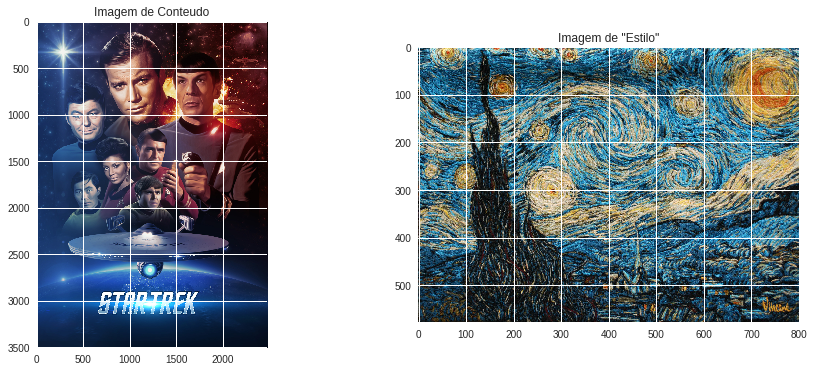

In [0]:
fig = plt.figure(figsize = (15, 6))
ax1 = fig.add_subplot(1,2, 1)
ax1.imshow(content_image)
t1 = ax1.set_title('Imagem de Conteudo')
ax2 = fig.add_subplot(1,2, 2)
ax2.imshow(style
t2 = ax2.set_title('Imagem de "Estilo"')

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


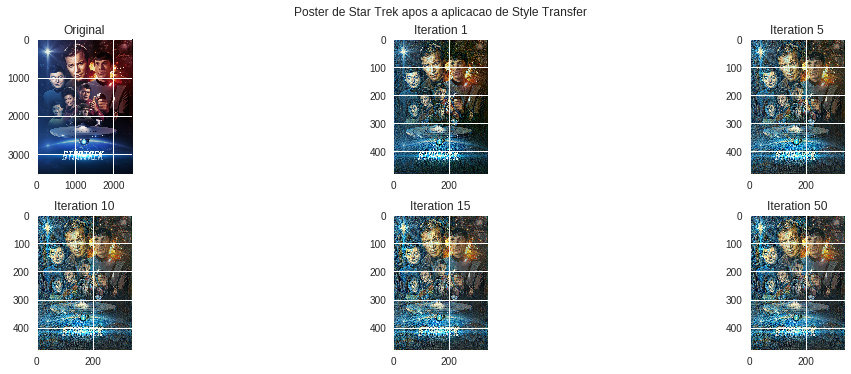

In [0]:
fig = plt.figure(figsize = (15, 15))

ax1 = fig.add_subplot(6,3, 1)
ax1.imshow(content_image)
t1 = ax1.set_title('Original')

ax1 = fig.add_subplot(6,3, 2)
ax1.imshow(iter1)
t1 = ax1.set_title('Iteration 1')

ax1 = fig.add_subplot(6,3, 3)
ax1.imshow(iter5)
t1 = ax1.set_title('Iteration 5')

ax1 = fig.add_subplot(6,3, 4)
ax1.imshow(iter10)
t1 = ax1.set_title('Iteration 10')

ax1 = fig.add_subplot(6,3, 5)
ax1.imshow(iter15)
t1 = ax1.set_title('Iteration 15')

ax1 = fig.add_subplot(6,3, 6)
ax1.imshow(iter20)
t1 = ax1.set_title('Iteration 20')

ax1 = fig.add_subplot(6,3, 6)
ax1.imshow(iter25)
t1 = ax1.set_title('Iteration 25')

ax1 = fig.add_subplot(6,3, 6)
ax1.imshow(iter30)
t1 = ax1.set_title('Iteration 30')

ax1 = fig.add_subplot(6,3, 6)
ax1.imshow(iter35)
t1 = ax1.set_title('Iteration 35')

ax1 = fig.add_subplot(6,3, 6)
ax1.imshow(iter40)
t1 = ax1.set_title('Iteration 40')

ax1 = fig.add_subplot(6,3, 6)
ax1.imshow(iter45)
t1 = ax1.set_title('Iteration 45')

ax1 = fig.add_subplot(6,3, 6)
ax1.imshow(iter50)
t1 = ax1.set_title('Iteration 50')

plt.tight_layout()
fig.subplots_adjust(top=0.95)
t = fig.suptitle('Poster de Star Trek apos a aplicacao de Style Transfer')

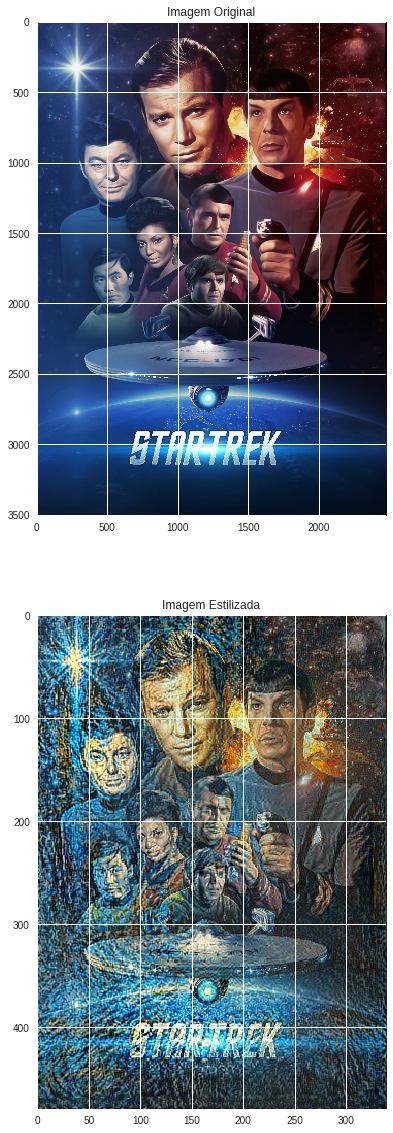

In [0]:
fig = plt.figure(figsize = (20, 20))

ax1 = fig.add_subplot(2,1, 1)
ax1.imshow(content_image)
t1 = ax1.set_title('Imagem Original')


ax1 = fig.add_subplot(2,1, 2)
ax1.imshow(iter50)
t1 = ax1.set_title('Imagem Estilizada')